# Model evaluation and drawing sheeeet

In [1]:
from models import *
from utils import set_seed
from data.loaders import * 

In [2]:
path_to_model = "/home/ajimenez/CoSE-pytorch/wandb/run-20210128_122647-3iw8z8ml/files/weights_trained"

In [3]:
set_seed(0)
device = torch.device('cuda:2')
cose = CoSEModel('config.json', False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"epoch_2/encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"epoch_2/decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"epoch_2/pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"epoch_2/emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [4]:
val_path = "/data/ajimenez/cose/valid/"

In [5]:
batchdata = BatchCoSELoader(path = val_path,
                    filenames={"inputs_file" : "valid_inputs_list_based_x16.pkl",
                                "targets_file": "valid_target_list_based_x16.pkl"}
                )

valid_loader = DataLoader(dataset =batchdata,
                batch_size = 1, #data is already in batch mode, batch_size = 1 means iterating every .get_next() returns a new batch
                )

In [6]:
from utils.visualization import * 

In [7]:
stats_json = 'didi_wo_text-stats-origin_abs_pos.json'
stats_path = '/data/jcabrera/didi_wo_text/'
with open(os.path.join(stats_path, stats_json)) as json_file:
    stats = json.load(json_file)

In [8]:
mean_channel = stats['mean_channel'][:2]
std_channel = np.sqrt(stats['var_channel'][:2])

In [9]:
log_dir = '/home/ajimenez/pruebas'

In [12]:
for batch_input, batch_target in iter(valid_loader):
    break

In [13]:
i_diagram = 7

In [14]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
seq_len_drawing = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()

In [15]:
enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = seq_len_drawing.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

In [16]:
i_diagram = 5

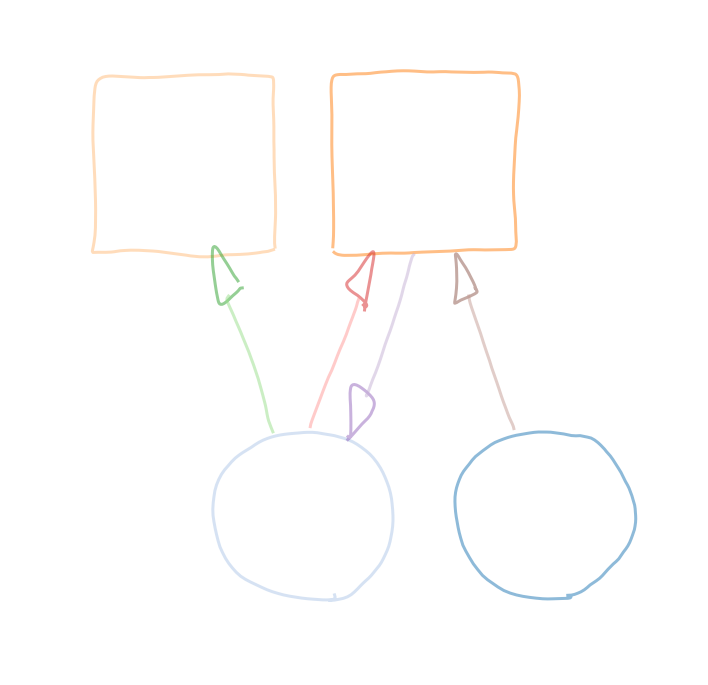

In [17]:
fig, _ = transform_strokes_to_image(enc_inputs[i_diagram], log_dir, 'noutput_pruebas', seq_len[i_diagram], st_coord[i_diagram],
                                    mean_channel, std_channel, num_strokes[i_diagram], square_figure=True, alpha=0.5)

## Pasando data por el modelo

In [47]:
device = "cuda:2"

In [48]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0).to(device)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0).to(device)
strok_len_inputs = batch_input['seq_len'].squeeze(dim = 0).to(device)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze().to(device)
end_coord = batch_input['end_coord'].squeeze(dim = 0).squeeze().to(device)

In [49]:
_, look_ahead_mask, _ = generate_3d_mask(encoder_inputs, strok_len_inputs,'cuda:2')

In [50]:
encoder_out = cose.encoder(encoder_inputs.permute(1,0,2), strok_len_inputs, look_ahead_mask)

In [51]:
diagram_embedding, padded_max_num_strokes, _, num_diagrams = reshape_stroke2diagram(encoder_out,num_strokes)

In [52]:
start_pos_base = start_coord.reshape(num_diagrams,padded_max_num_strokes,2)

In [53]:
pos_model_inputs = torch.cat([diagram_embedding, start_pos_base], dim = 2)

In [57]:
pos_pred_mu, pos_pred_sigma, pos_pred_pi = cose.position_predictive_model(pos_model_inputs, num_strokes, None)

/home/ajimenez/CoSE-pytorch/models/gmm.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out_pi = torch.nn.functional.softmax(out_pi)


In [58]:
pos_model_output = cose.position_predictive_model.draw_sample(pos_pred_mu, pos_pred_sigma, pos_pred_pi)

In [70]:
pred_model_inputs = torch.cat([diagram_embedding, start_pos_base, pos_model_output.unsqueeze(dim = 1).repeat(1, diagram_embedding.size(1), 1)], dim = 2)

In [71]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pred_model_inputs, num_strokes, None)

In [72]:
strokes_output = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi)

In [74]:
strokes_output.shape

torch.Size([8, 8])

In [ ]:
points_q = 6

In [ ]:
t_inputs = (0, 0.2, 0.4 0.6 0.8 1) #6 puntos  #(8, points_q)

In [ ]:
#flatten t_inputs (48, 1)
#repeat or tile strokes_output (batch_sizexpoints_q, 8) -> (48,8)
#concat t_inputs + strokes_output_reshapeo #(batch_sizexpoints_q, 9)
# entra al decoder
#draw sample del decoder

In [ ]:
#dim (batch_size, embedding_size + 1)

In [1]:
from data.loaders import *

In [2]:
from utils import * 

In [4]:
data_loader = get_batch_iterator("/data/ajimenez/cose/train")

In [5]:
for batch_input, batch_target in iter(data_loader):
    print(batch_input['seq_len'].shape)
    sys.exit(0)

torch.Size([1, 96])


NameError: name 'sys' is not defined

In [12]:
batch_input['encoder_inputs'][0][3]

tensor([[-0.3041, -0.2503,  0.0000],
        [-0.4012, -0.4150,  0.0000],
        [-0.4784, -0.5985,  0.0000],
        [-0.5537, -0.7905,  0.0000],
        [-0.6289, -0.9824,  0.0000],
        [-0.6912, -1.1436,  0.0000],
        [-0.7417, -1.2636,  0.0000],
        [-0.7781, -1.3270,  0.0000],
        [-0.8084, -1.3429,  0.0000],
        [-0.8336, -1.3170,  0.0000],
        [-0.8636, -1.2630,  0.0000],
        [-0.9032, -1.1738,  0.0000],
        [-0.9560, -1.0703,  0.0000],
        [-1.0152, -0.9718,  0.0000],
        [-1.0801, -0.8670,  0.0000],
        [-1.1302, -0.7882,  0.0000],
        [-1.1652, -0.7264,  0.0000],
        [-1.1786, -0.6887,  0.0000],
        [-1.1768, -0.6673,  0.0000],
        [-1.1597, -0.6535,  0.0000],
        [-1.1239, -0.6323,  0.0000],
        [-1.0716, -0.5946,  0.0000],
        [-1.0104, -0.5299,  0.0000],
        [-0.9465, -0.4376,  0.0000],
        [-0.8798, -0.3120,  0.0000],
        [-0.8301, -0.1725,  0.0000],
        [-0.7940, -0.0368,  0.0000],
 